## Are we seeing a reduction in collisions related to changing speed limits

In [1]:
import pandas as pd
from neighborhood_reader import get_neighborhood, assign_neighborhood
from causalimpact import CausalImpact
import geopandas as gpd

## Step 1: Import data

In [2]:
df = pd.read_csv("../wa_collisions/data/Collisions_With_Neighborhoods_test.csv")

In [8]:
df.incdate.sort_values()

24    2004-03-08T00:00:00.000Z
46    2004-05-01T00:00:00.000Z
44    2004-11-17T00:00:00.000Z
9     2005-03-16T00:00:00.000Z
12    2009-11-01T00:00:00.000Z
13    2010-10-13T00:00:00.000Z
65    2013-03-28T00:00:00.000Z
11    2013-03-29T00:00:00.000Z
47    2014-02-27T00:00:00.000Z
71    2015-05-15T00:00:00.000Z
69    2016-04-20T00:00:00.000Z
79    2016-10-29T00:00:00.000Z
90    2016-11-03T00:00:00.000Z
21    2016-11-04T00:00:00.000Z
27    2016-11-07T00:00:00.000Z
43    2016-11-08T00:00:00.000Z
42    2016-11-13T00:00:00.000Z
87    2016-11-13T00:00:00.000Z
0     2016-11-13T00:00:00.000Z
86    2016-11-27T00:00:00.000Z
75    2016-12-01T00:00:00.000Z
84    2016-12-02T00:00:00.000Z
58    2016-12-03T00:00:00.000Z
38    2016-12-03T00:00:00.000Z
31    2016-12-03T00:00:00.000Z
82    2016-12-07T00:00:00.000Z
81    2016-12-11T00:00:00.000Z
91    2016-12-16T00:00:00.000Z
35    2016-12-18T00:00:00.000Z
34    2016-12-19T00:00:00.000Z
                ...           
83    2017-03-02T00:00:00.000Z
8     20

In [175]:
df.columns

Index(['Unnamed: 0', 'X', 'Y', 'objectid', 'inckey', 'coldetkey', 'addrtype',
       'collisiontype', 'exceptrsncode', 'exceptrsndesc', 'fatalities',
       'inattentionind', 'incdate', 'incdttm', 'injuries', 'intkey',
       'junctiontype', 'lightcond', 'location', 'pedcount', 'pedcylcount',
       'pedrownotgrnt', 'personcount', 'reportno', 'roadcond', 'sdot_colcode',
       'sdot_coldesc', 'sdotcolnum', 'seriousinjuries', 'severitycode',
       'severitydesc', 'speeding', 'st_colcode', 'st_coldesc', 'status',
       'underinfl', 'vehcount', 'weather', 'seglanekey', 'crosswalkkey',
       'hitparkedcar', 'object_id'],
      dtype='object')

In [176]:
NEIGHBORHOODS = gpd.read_file('../wa_collisions/data/Neighborhoods/Neighborhoods.json')
NEIGHBORHOODS_COUNT = len(NEIGHBORHOODS)

In [177]:
NEIGHBORHOODS['S_HOOD'].unique()

array(['OOO', 'Loyal Heights', 'Adams', 'Whittier Heights',
       'West Woodland', 'Phinney Ridge', 'Wallingford', 'Fremont',
       'Green Lake', 'View Ridge', 'Ravenna', 'Sand Point', 'Bryant',
       'Windermere', 'Laurelhurst', 'Roosevelt', 'University District',
       'East Queen Anne', 'West Queen Anne', 'Lower Queen Anne',
       'North Queen Anne', 'Westlake', 'Eastlake', 'South Lake Union',
       'Lawton Park', 'Briarcliff', 'Southeast Magnolia', 'Madrona',
       'Harrison/Denny-Blaine', 'Minor', 'Leschi', 'Mann', 'Atlantic',
       'Pike-Market', 'Belltown', 'International District',
       'Central Business District', 'First Hill', 'Yesler Terrace',
       'Pioneer Square', 'Interbay', 'Industrial District', 'Georgetown',
       'South Park', 'Harbor Island', 'Seaview', 'Gatewood',
       'Arbor Heights', 'Alki', 'North Admiral', 'Fairmount Park',
       'Genesee', 'Fauntleroy', 'North Beacon Hill', 'Mid-Beacon Hill',
       'South Beacon Hill', 'Holly Park', 'Brighton',

## Step 2: Data clean-up

### Identify neighborhoods where speed limits changed

Identify neighborhoods where speed limit changed and those where it didn't

In [178]:
speed_limit_nbrhood = ['Atlantic','Pike-Market', 'Belltown', 'International District',
       'Central Business District', 'First Hill', 'Yesler Terrace',
       'Pioneer Square', 'Interbay','Mann','Minor']
no_speed_limit_nbrhood = list(set(NEIGHBORHOODS['S_HOOD'].unique()) - set(speed_limit_nbrhood))

Convert names to object ids

In [201]:
speed_limit_nbrhood_id = []
for i in range(0,len(speed_limit_nbrhood)):
    speed_limit_nbrhood_id = speed_limit_nbrhood_id + [int(NEIGHBORHOODS[NEIGHBORHOODS['S_HOOD'] == speed_limit_nbrhood[i]]['OBJECTID'])]
no_speed_limit_nbrhood_id = list(set(NEIGHBORHOODS['OBJECTID'].unique()) - set(speed_limit_nbrhood_id))

In [202]:
df = df[df['object_id'].isin(speed_limit_nbrhood_id) | df['object_id'].isin(no_speed_limit_nbrhood_id)]

### Add speed limit flag to dataframe and group collisions data by date 

In [203]:
df['speedlimit_change_flag'] =  df['object_id'].isin(speed_limit_nbrhood_id)

In [320]:
df[df['speedlimit_change_flag'] ==True]['object_id'].unique()

array([57., 58., 64., 61., 55., 65., 63., 59., 60., 62., 66.])

In [204]:
df.head(1).T

,0
Unnamed: 0,0
X,-122.342
Y,47.6276
objectid,162244138
inckey,233006
coldetkey,233406
addrtype,Block
collisiontype,Head On
exceptrsncode,
exceptrsndesc,NaN


In [205]:
print('min date:',df['incdate'].min())
print('max date:',df['incdate'].max())

min date: 2003-10-06 00:00:00
max date: 2018-03-29 00:00:00


### Define periods before and after speed limit change

In [206]:
pre_period  = [pd.to_datetime(date) for date in ["2013-10-06", "2016-09-30"]]
post_period = [pd.to_datetime(date) for date in ["2016-10-01", "2018-03-29"]]

In [207]:
df['incdate'] = pd.to_datetime(df['incdate'])

### Create dataframe for input to causal impact

In [208]:
#def create_causal_impact_frame(input_frame,)
data_all = df.groupby(['incdate','speedlimit_change_flag']).size()
data_all = data_all.unstack()
data_all = data_all.fillna(0)
data_all = data_all.rename(columns={True: "SpeedLimitChange", False: "SpeedLimitSame"})
data_all = data_all[['SpeedLimitChange','SpeedLimitSame']]

In [209]:
data_all.head(1)

speedlimit_change_flag,SpeedLimitChange,SpeedLimitSame
incdate,,
2003-10-06,1.0,0.0


In [210]:
data_all.corr()

speedlimit_change_flag,SpeedLimitChange,SpeedLimitSame
speedlimit_change_flag,,
SpeedLimitChange,1.000000,0.386991
SpeedLimitSame,0.386991,1.000000


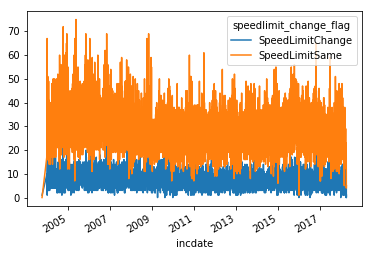

In [211]:
data_all.plot()

### Run causal impact by day

In [212]:
impact = CausalImpact(data_all, pre_period, post_period)
impact.run()

In [213]:
impact.summary()

                         Average       Cumulative
Actual                         6             3793
Predicted                      6             3793
95% CI                   [0, 13]      [366, 7220]
                                                 
Absolute Effect                0                0
95% CI                   [6, -6]    [3426, -3427]
                                                 
Relative Effect            -0.0%            -0.0%
95% CI           [90.3%, -90.4%]  [90.3%, -90.4%]


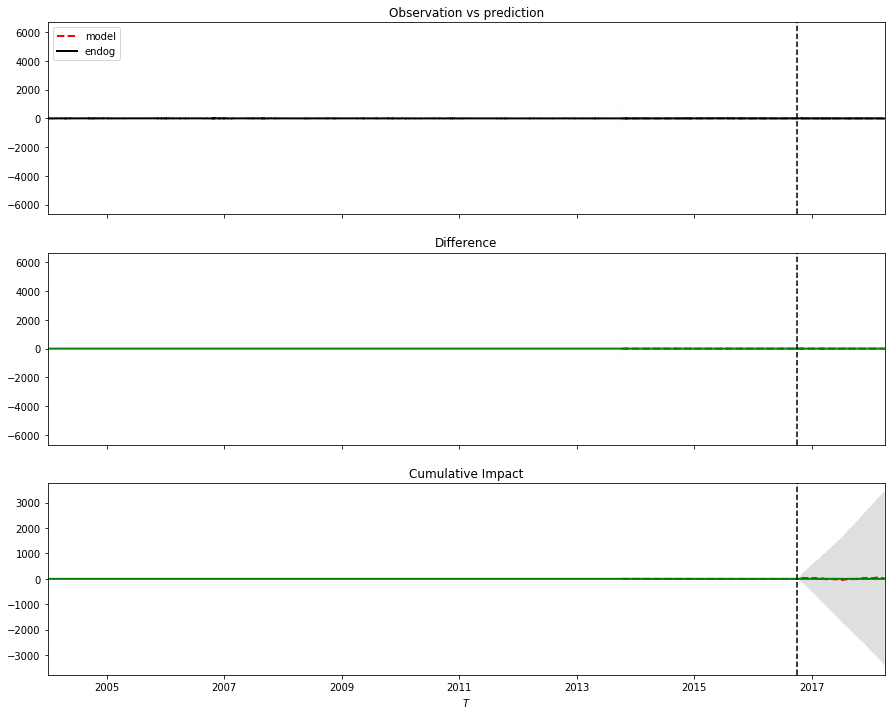

In [214]:
impact.plot()

### Group data by week and month

In [251]:
data_week = data_all.resample('W', how='sum')
data_month = data_all.resample('M', how='sum')

C:\Users\geoffc.REDMOND\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.
C:\Users\geoffc.REDMOND\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  


In [216]:
##Find the end of the pre_period in terms of weeks, months

In [217]:
pre_period_wk  = [pd.to_datetime(date) for date in ["2003-10-12", "2016-10-02"]]
post_period_wk = [pd.to_datetime(date) for date in ["2016-10-09", "2018-04-01"]]

pre_period_month  = [pd.to_datetime(date) for date in ["2003-10-31", "2016-09-30"]]
post_period_month = [pd.to_datetime(date) for date in ["2016-10-31", "2018-03-31"]]

In [218]:
data_week.head()

speedlimit_change_flag,SpeedLimitChange,SpeedLimitSame
incdate,,
2003-10-12,1.0,0.0
2003-10-19,0.0,0.0
2003-10-26,0.0,0.0
2003-11-02,0.0,0.0
2003-11-09,0.0,0.0


### Re-analyze by week

In [219]:
impact_wk = CausalImpact(data_week, pre_period_wk, post_period_wk)
impact_wk.run()

In [220]:
impact_wk.summary()

                         Average       Cumulative
Actual                        48             3781
Predicted                     47             3719
95% CI                  [30, 65]     [2352, 5085]
                                                 
Absolute Effect                0               61
95% CI                 [18, -16]    [1428, -1304]
                                                 
Relative Effect             1.7%             1.7%
95% CI           [38.4%, -35.1%]  [38.4%, -35.1%]


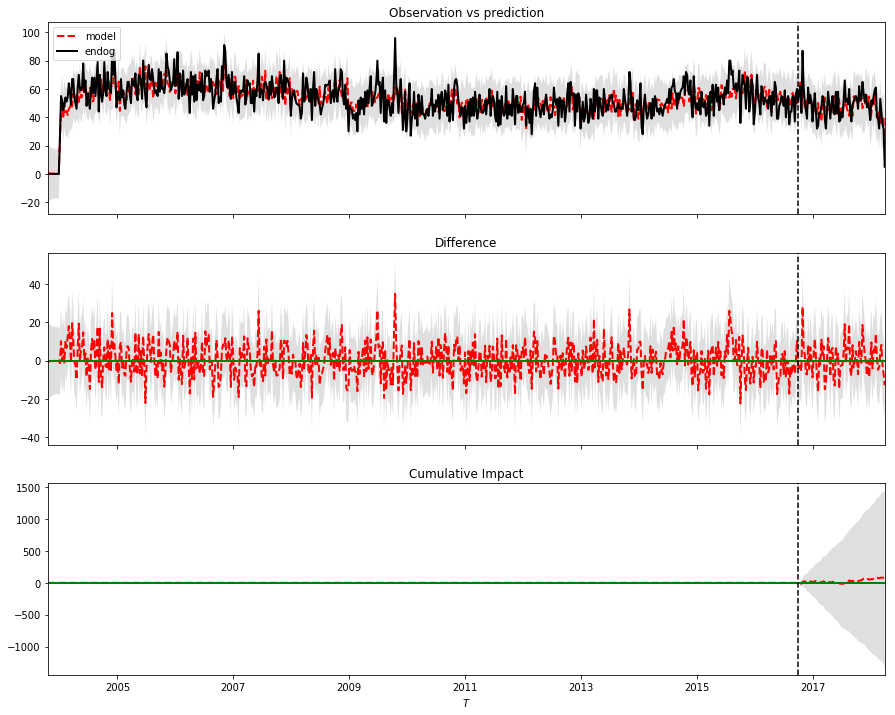

In [221]:
impact_wk.plot()

In [222]:
impact_mth = CausalImpact(data_month, pre_period_month, post_period_month)
impact_mth.run()

In [223]:
impact_mth.summary()

                         Average       Cumulative
Actual                       210             3793
Predicted                    211             3798
95% CI                [172, 249]     [3103, 4494]
                                                 
Absolute Effect                0               -5
95% CI                 [38, -38]      [689, -701]
                                                 
Relative Effect            -0.1%            -0.1%
95% CI           [18.2%, -18.5%]  [18.2%, -18.5%]


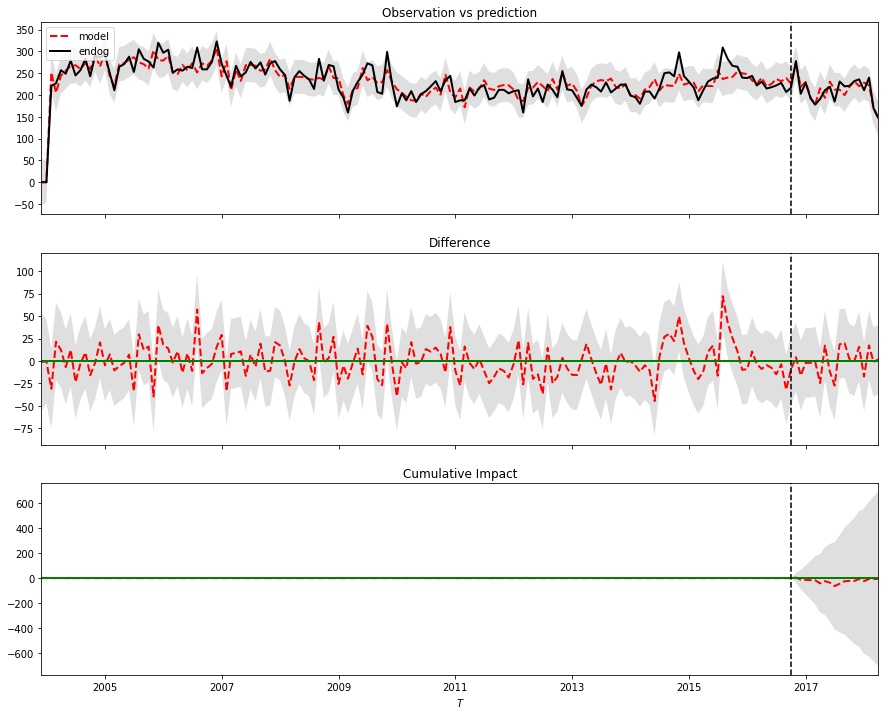

In [224]:
impact_mth.plot()

### What happens when we look at speeding by month?

In [228]:
df_in = df[df['speeding']=='Y']
data_all = df_in.groupby(['incdate','speedlimit_change_flag']).size()
data_all = data_all.unstack()
data_all = data_all.fillna(0)
data_all = data_all.rename(columns={True: "SpeedLimitChange", False: "SpeedLimitSame"})
data_all = data_all[['SpeedLimitChange','SpeedLimitSame']]

In [229]:
data_month = data_all.resample('M', how='sum')

C:\Users\geoffc.REDMOND\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


In [230]:
data_month.tail()

speedlimit_change_flag,SpeedLimitChange,SpeedLimitSame
incdate,,
2017-09-30,0.0,0.0
2017-10-31,3.0,20.0
2017-11-30,11.0,44.0
2017-12-31,6.0,48.0
2018-01-31,6.0,38.0


In [231]:
pre_period_month  = [pd.to_datetime(date) for date in ["2004-01-31", "2016-09-30"]]
post_period_month = [pd.to_datetime(date) for date in ["2016-10-31", "2018-01-31"]]

In [232]:
impact_mth = CausalImpact(data_month, pre_period_month, post_period_month)
impact_mth.run()

In [233]:
impact_mth.summary()

                           Average         Cumulative
Actual                           5                 82
Predicted                        5                 94
95% CI                     [0, 12]         [-14, 203]
                                                     
Absolute Effect                  0                -12
95% CI                     [6, -7]         [96, -121]
                                                     
Relative Effect             -13.6%             -13.6%
95% CI           [101.3%, -128.4%]  [101.3%, -128.4%]


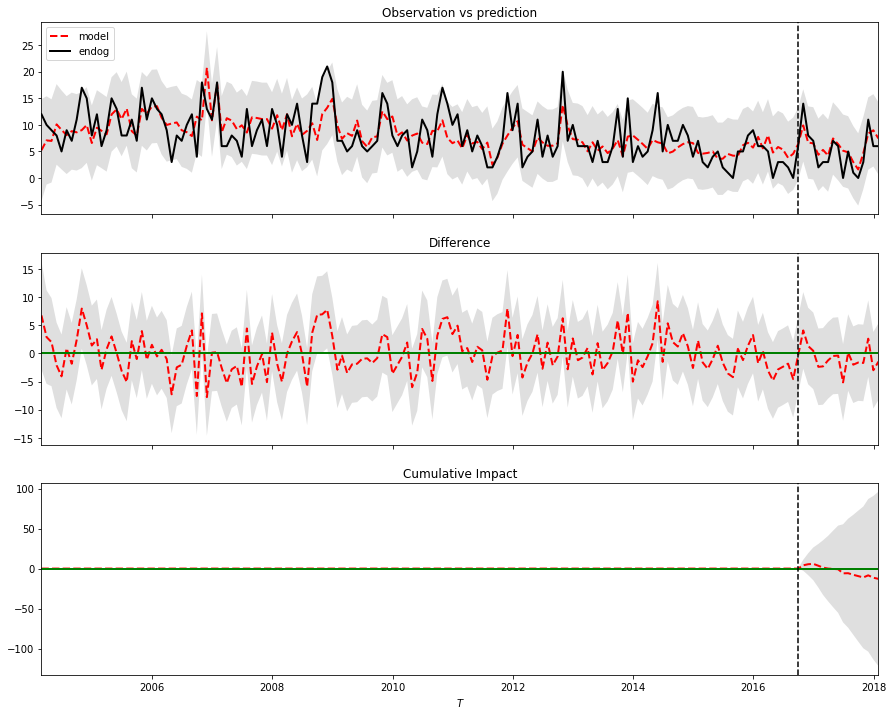

In [234]:
impact_mth.plot()

### What happens when we look at accidents with injuries per month?

In [235]:
df.groupby('injuries').size()

injuries
0     135850
1      40540
2       9218
3       2393
4        723
5        244
6         89
7         34
8         12
9          9
10         6
11         5
12         1
13         2
15         1
dtype: int64

In [318]:
speed_limit_nbrhood = ['Atlantic','Pike-Market', 'Belltown', 'International District',
       'Central Business District', 'First Hill', 'Yesler Terrace',
       'Pioneer Square', 'Interbay','Mann','Minor']
no_speed_limit_nbrhood = list(set(NEIGHBORHOODS['S_HOOD'].unique()) - set(speed_limit_nbrhood))

In [285]:
df_in = df[df['injuries']>0]
data_all = df_in.groupby(['incdate','speedlimit_change_flag']).size()
data_all = data_all.unstack()
data_all = data_all.fillna(0)
data_all = data_all.rename(columns={True: "SpeedLimitChange", False: "SpeedLimitSame"})
data_all = data_all[['SpeedLimitChange','SpeedLimitSame']]

In [324]:
data_month = data_all.resample('M', how='sum')

C:\Users\geoffc.REDMOND\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


In [325]:
data_month.tail()

speedlimit_change_flag,SpeedLimitChange,SpeedLimitSame
incdate,,
2017-11-30,79.0,233.0
2017-12-31,63.0,236.0
2018-01-31,56.0,240.0
2018-02-28,26.0,136.0
2018-03-31,12.0,61.0


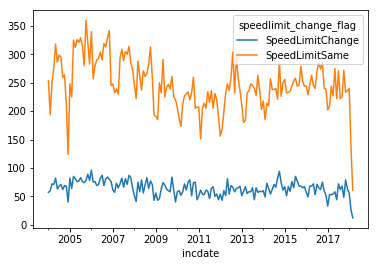

In [239]:
data_month.plot()

In [240]:
data_month.corr()

speedlimit_change_flag,SpeedLimitChange,SpeedLimitSame
speedlimit_change_flag,,
SpeedLimitChange,1.000000,0.695845
SpeedLimitSame,0.695845,1.000000


In [241]:
pre_period_month  = [pd.to_datetime(date) for date in ["2004-01-31", "2016-09-30"]]
post_period_month = [pd.to_datetime(date) for date in ["2016-10-31", "2018-01-31"]]

In [242]:
impact_mth = CausalImpact(data_month, pre_period_month, post_period_month,model_args={"nseasons":12})
impact_mth.run()

In [243]:
impact_mth.summary()

                         Average       Cumulative
Actual                        58              930
Predicted                     63             1023
95% CI                  [46, 81]      [743, 1303]
                                                 
Absolute Effect               -5              -93
95% CI                 [11, -23]      [186, -373]
                                                 
Relative Effect            -9.2%            -9.2%
95% CI           [18.2%, -36.5%]  [18.2%, -36.5%]


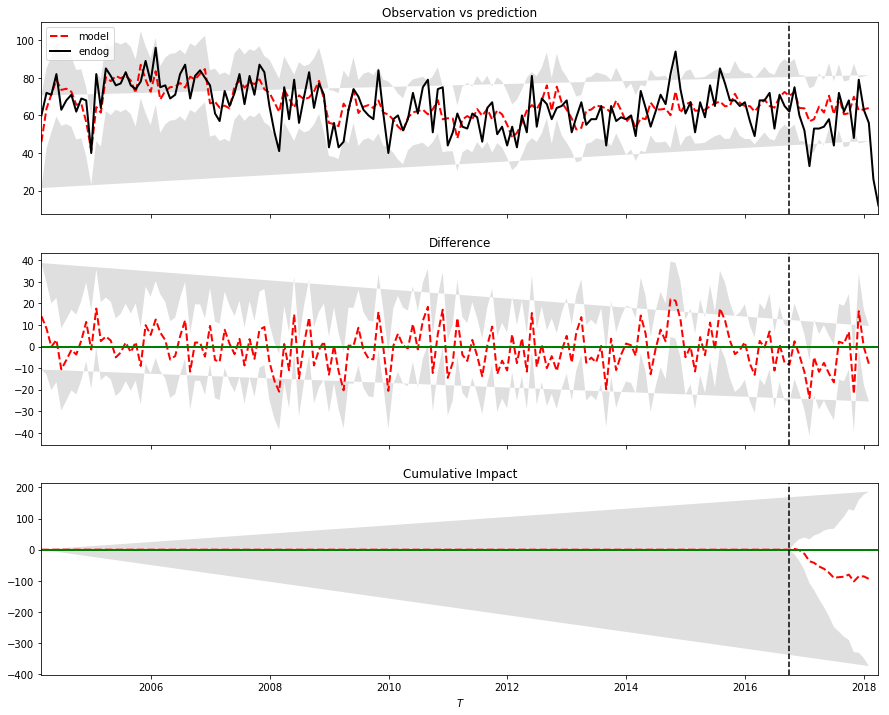

In [244]:
impact_mth.plot(["original","cumulative", "pointwise"])

### What happens when we look at number of injuries?

In [245]:
df_in = df[df['injuries']>0]
data_all = df_in.groupby(['incdate','speedlimit_change_flag'])['injuries'].sum()
data_all = data_all.unstack()
data_all = data_all.fillna(0)
data_all = data_all.rename(columns={True: "SpeedLimitChange", False: "SpeedLimitSame"})
data_all = data_all[['SpeedLimitChange','SpeedLimitSame']]

In [246]:
data_month = data_all.resample('M', how='sum')

C:\Users\geoffc.REDMOND\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


In [247]:
data_month.corr()

speedlimit_change_flag,SpeedLimitChange,SpeedLimitSame
speedlimit_change_flag,,
SpeedLimitChange,1.000000,0.677809
SpeedLimitSame,0.677809,1.000000


In [248]:
impact_mth = CausalImpact(data_month, pre_period_month, post_period_month,model_args={"nseasons":12})
impact_mth.run()

In [249]:
impact_mth.summary()

                         Average       Cumulative
Actual                        75             1205
Predicted                     80             1292
95% CI                 [54, 106]      [875, 1710]
                                                 
Absolute Effect               -5              -87
95% CI                 [20, -31]      [329, -505]
                                                 
Relative Effect            -6.8%            -6.8%
95% CI           [25.5%, -39.1%]  [25.5%, -39.1%]


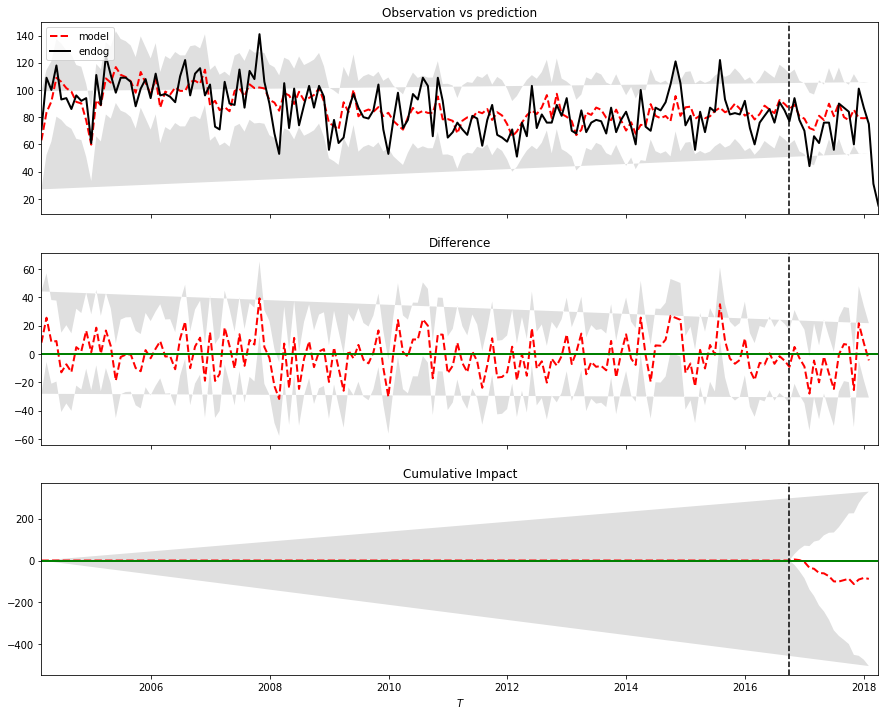

In [250]:
impact_mth.plot(["original","cumulative", "pointwise"])

In [254]:
'object_id' in df.columns

True

In [329]:
data_month.index.min().month

1

In [311]:
from datetime import datetime
transition_datetime = datetime.strptime("2017-01-02",'%Y-%m-%d')
transition_datetime > data_month.index.max()

actual = data_month.ix[data_month.index.get_loc(transition_datetime,method='nearest')+1].name
actual

Timestamp('2016-12-31 00:00:00', freq='M')

In [313]:
actual.strftime('%Y-%m-%d')

'2016-12-31'

In [317]:
df.head().shape[0]

5